In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [2]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.60
transformers version : 2.5.1


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
train = pd.read_csv("/kaggle/input/sst-2-dataset/train.csv")
validation = pd.read_csv("/kaggle/input/sst-2-dataset/validation.csv")
test = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
print(train.shape,test.shape)

(67349, 3) (50000, 2)


In [4]:
train.head()

,idx,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0


In [5]:
test.rename(columns={'review': 'sentence', 'sentiment': 'label'}, inplace=True)

test['label'] = test['label'].map({'negative': 0, 'positive': 1})

output_path = "/kaggle/working/modified_imdb_dataset.csv"
test.to_csv(output_path, index=False)

test.head()

,sentence,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [6]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [7]:
# Parameters
seed = 42
use_fp16 = False
bs = 12

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [8]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [9]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [10]:
seed_all(seed)

In [11]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [12]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [13]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [14]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [15]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

In [16]:
databunch = (TextList.from_df(train, cols='sentence', processor=transformer_processor)
             .split_none()
             .label_from_df(cols= 'label')
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [17]:
valid_databunch = (TextList.from_df(validation, cols='sentence', processor=transformer_processor)
             .split_none()
             .label_from_df(cols= 'label')
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [18]:
test_databunch = (TextList.from_df(test, cols='sentence', processor=transformer_processor)
             .split_none()
             .label_from_df(cols= 'label')
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [19]:
import torch.tensor as Tensor
def dropout_mask(x:Tensor, sz, p:float):
    "Return a dropout mask of the same type as x, size sz, with probability p to cancel an element."
    return x.new(*sz).bernoulli_(1-p).div_(1-p)

class RNNDropout(nn.Module):
    "Dropout with probability p that is consistent on the seq_len dimension."

    def __init__(self, p:float=0.5): 
        super(RNNDropout, self).__init__()
        self.p=p

    def forward(self, x:Tensor)->Tensor:
        if not self.training or self.p == 0.: return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m

class WeightDropout(nn.Module):
    "A module that warps another layer in which some weights will be replaced by 0 during training."

    def __init__(self, module:nn.Module, weight_p:float, layer_names=['weight_hh_l0']):
        super(WeightDropout, self).__init__()
        self.module,self.weight_p,self.layer_names = module,weight_p,layer_names
        for layer in self.layer_names:
            #Makes a copy of the weights of the selected layers.
            w = getattr(self.module, layer)
            # Registered in list of parameters
            self.register_parameter(str(layer)+'_raw', nn.Parameter(w.data))
            self.module._parameters[layer] = F.dropout(w, p=self.weight_p, training=False)

    def _setweights(self):
        "Apply dropout to the raw weights."
        for layer in self.layer_names:
            raw_w = getattr(self, str(layer) +'_raw')
            self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=self.training)

    def forward(self, *args):
        self._setweights()
        with warnings.catch_warnings():
            #To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")
            return self.module.forward(*args)

    def reset(self):
        for layer in self.layer_names:
            raw_w = getattr(self, str(layer) + '_raw')
            self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=False)
        if hasattr(self.module, 'reset'): self.module.reset()

In [20]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        self.transformer = self.transformer
        self.rnns = [nn.LSTM(768 if l == 0 else 1152,
                            (1152 if l != 2-1 else 768)//2,
                            1, bidirectional = True, batch_first = True) for l in range(2)]
        
        
        self.rnns = [WeightDropout(rnn, 0.4) for rnn in self.rnns]
        self.rnns = nn.ModuleList(self.rnns)
        self.hidden_dps = nn.ModuleList([RNNDropout(0.5) for l in range(2)])
        self.out = nn.Linear(768,2)
        self.bs = bs
        
    def forward(self, input_ids, attention_mask=None):
        self.bs =input_ids.shape[0]
        self.reset()
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in `[0, 1]`:
        # `1` for tokens that are NOT MASKED, `0` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        raw_output = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]
#         print(raw_output.shape)
# #         hidden, _ = self.rnns(logits)
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns,self.hidden_dps)):
            raw_output,_ = rnn(raw_output, self.hidden[l])
            if l != 2-1:raw_output = hid_dp(raw_output)
        output = self.out(raw_output)
        return output.mean(1).squeeze()
    def _one_hidden(self, l:int)->Tensor:
        "Return one hidden state."
        nh = (1152 if l != 1 else 768) //2
        return torch.zeros(2,self.bs,nh).cuda()
    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(2)]

In [21]:
from transformers import RobertaTokenizer, RobertaModel
# transformer_model = RobertaModel.from_pretrained("/kaggle/input/realroberta")
transformer_model = RobertaModel.from_pretrained("roberta-base")

In [22]:
# transformer_model.embeddings.word_embeddings.weight

In [23]:
# transformer_model1 = RobertaModel.from_pretrained("roberta-base")
# transformer_model1.embeddings.word_embeddings.weight

In [24]:
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)
custom_transformer_model

CustomTransformerModel(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

In [25]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
# if use_fp16: learner = learner.to_fp16()

In [26]:
learner.data.valid_dl = valid_databunch.train_dl

In [27]:
# For DistilBERT
# list_layers = [learner.model.transformer.embeddings,
#                learner.model.transformer.transformer.layer[0],
#                learner.model.transformer.transformer.layer[1],
#                learner.model.transformer.transformer.layer[2],
#                learner.model.transformer.transformer.layer[3],
#                learner.model.transformer.transformer.layer[4],
#                learner.model.transformer.transformer.layer[5]]

# For xlnet-base-cased
# list_layers = [learner.model.transformer.word_embedding,
#               learner.model.transformer.layer[0],
#               learner.model.transformer.layer[1],
#               learner.model.transformer.layer[2],
#               learner.model.transformer.layer[3],
#               learner.model.transformer.layer[4],
#               learner.model.transformer.layer[5],
#               learner.model.transformer.layer[6],
#               learner.model.transformer.layer[7],
#               learner.model.transformer.layer[8],
#               learner.model.transformer.layer[9],
#               learner.model.transformer.layer[10],
#               learner.model.transformer.layer[11]]

# For roberta-base
list_layers = [learner.model.transformer.embeddings,
              learner.model.transformer.encoder.layer[0],
              learner.model.transformer.encoder.layer[1],
              learner.model.transformer.encoder.layer[2],
              learner.model.transformer.encoder.layer[3],
              learner.model.transformer.encoder.layer[4],
              learner.model.transformer.encoder.layer[5],
              learner.model.transformer.encoder.layer[6],
              learner.model.transformer.encoder.layer[7],
              learner.model.transformer.encoder.layer[8],
              learner.model.transformer.encoder.layer[9],
              learner.model.transformer.encoder.layer[10],
              learner.model.transformer.encoder.layer[11],
              learner.model.transformer.pooler,
              learner.model.rnns]

In [28]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


Learner split in 15 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2)

In [29]:
learner.save('untrain')
seed_all(seed)
learner.load('untrain');

In [30]:
learner.model.reset()
learner.freeze_to(-1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.307137,0.236553,0.913194,0.086806,02:18


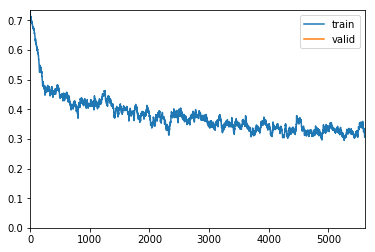

In [31]:
learner.fit_one_cycle(1,max_lr=1e-3,moms=(0.8,0.7))

In [32]:
learner.validate(test_databunch.train_dl)

[0.38462976, tensor(0.8205), tensor(0.1795)]

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.252643,0.187605,0.936343,0.063657,03:31


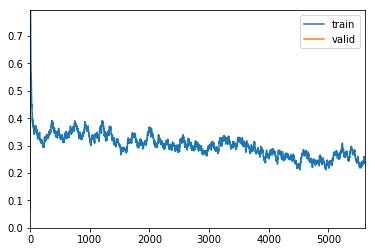

In [33]:
learner.freeze_to(-6)
lr = 1e-4
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.241882,0.189473,0.939815,0.060185,03:28


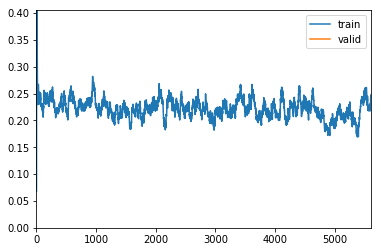

In [34]:
lr = 8e-7
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [35]:
learner.validate(test_databunch.train_dl)

[0.22217721, tensor(0.9156), tensor(0.0844)]

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.214810,0.194051,0.940972,0.059028,03:29


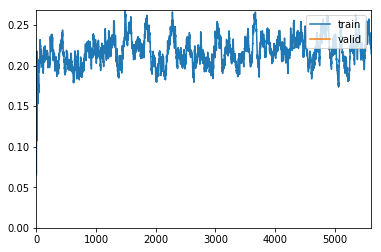

In [36]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [37]:
learner.validate(test_databunch.train_dl)

[0.22414586, tensor(0.9156), tensor(0.0844)]

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.148547,0.189316,0.943287,0.056713,06:45
1,0.137018,0.184006,0.944444,0.055556,06:33
2,0.119855,0.179825,0.945602,0.054398,06:38


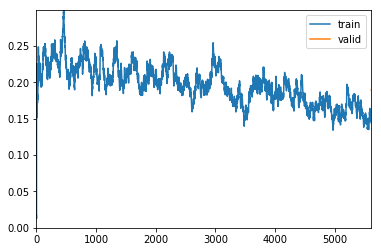

In [38]:
learner.unfreeze()

learner.fit_one_cycle(3, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [39]:
learner.validate(test_databunch.train_dl)

[0.22077005, tensor(0.9176), tensor(0.0824)]

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.131838,0.176303,0.945602,0.054398,06:52
1,0.142890,0.180469,0.943287,0.056713,06:30
2,0.124350,0.177981,0.946759,0.053241,06:58
3,0.111512,0.189382,0.945602,0.054398,06:57
4,0.107216,0.178930,0.946759,0.053241,06:46


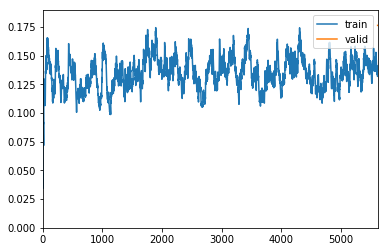

In [40]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [41]:
learner.validate(test_databunch.train_dl)

[0.23204678, tensor(0.9184), tensor(0.0816)]

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.124885,0.180153,0.946759,0.053241,06:32
1,0.113167,0.186625,0.952546,0.047454,06:52
2,0.126242,0.193694,0.943287,0.056713,06:43
3,0.089033,0.199561,0.947917,0.052083,06:59
4,0.081167,0.184178,0.949074,0.050926,06:53
5,0.099088,0.203704,0.946759,0.053241,06:37
6,0.081112,0.204826,0.951389,0.048611,06:44
7,0.075422,0.195436,0.949074,0.050926,06:47
8,0.093727,0.200381,0.950231,0.049769,07:02
9,0.083027,0.204536,0.946759,0.053241,06:45


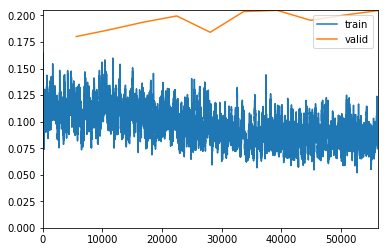

In [42]:
learner.fit_one_cycle(10, max_lr=slice(lr*0.95**num_groups, lr))

In [43]:
interp = ClassificationInterpretation.from_learner(learner)

interp 

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       413
           1       0.96      0.94      0.95       451

    accuracy                           0.95       864
   macro avg       0.95      0.95      0.95       864
weighted avg       0.95      0.95      0.95       864



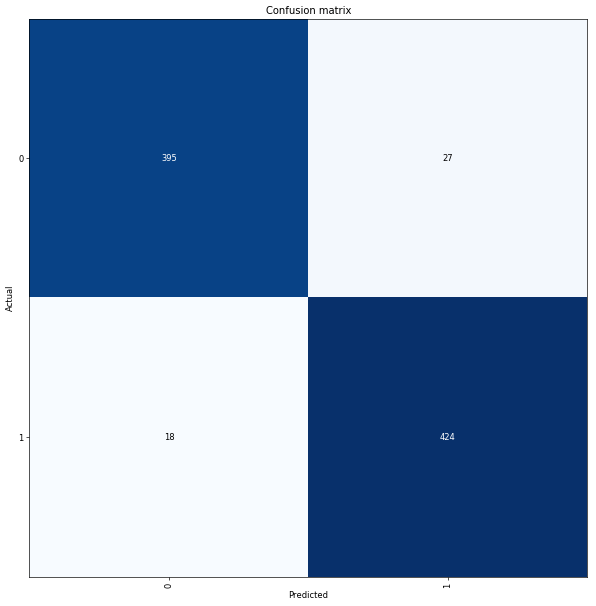

In [56]:
from sklearn.metrics import classification_report

interp = ClassificationInterpretation.from_learner(learner)

interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

y_true = interp.preds.argmax(dim=1)
y_pred = interp.y_true

# Print the classification report
report = classification_report(y_true, y_pred)
print(report)